## Import necessary packages

In [1]:
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from copy import deepcopy
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch import nn
import numpy as np
import random
import random
import torch
import time
import os

## Set hyperparameters and constant values

In [2]:
TRAIN_DIR = 'Training/'
TEST_DIR = 'Testing/'
IMG_SIZE = 224
TRAIN_BATCHSIZE = 200
EVAL_BATCHSIZE = 10
EPOCHS = 10
TRAIN_FRACTION = 0.8
TEST_FRACTION = 0.1
VALIDATION_FRACTION = 0.1
DATA_LABELS = {0: 'glioma', 1: 'meningioma', 2: 'no_tumor', 3: 'pituitary'}

## Define function for plotting images in datasets

In [3]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def plot_sample_images(dataset, num_samples_per_class=4):
    samples = defaultdict(list)
    class_counter = Counter()
    
    for img, label in dataset:
        if class_counter[label] < num_samples_per_class:
            samples[label].append(img)
            class_counter[label] += 1
        
        if all(count >= num_samples_per_class for count in class_counter.values()):
            break
        
    num_classes = len(samples)
    if num_classes == 1:
        fig, axes = plt.subplots(1, num_samples_per_class, figsize=(15, 5))
        axes = np.expand_dims(axes, axis=0)  # Convert to 2D array
    else:
        fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 5 * num_classes))

    for i, (label, imgs) in enumerate(samples.items()):
        for j, img in enumerate(imgs):
            img_np = img.permute(1, 2, 0).cpu().numpy() if img.dim() == 3 else img.cpu().numpy()
            axes[i, j].imshow(img_np, cmap='gray')
            axes[i, j].axis('off')
            
        axes[i, 0].set_title(DATA_LABELS[label])

    plt.show()


## Instantiate dataset classes

In [4]:
def get_dataset_info(data_dir):
    image_paths = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image_paths.append(image_path)
                labels.append(class_name)
    return image_paths, labels

train_image_paths, train_labels = get_dataset_info(TRAIN_DIR)
test_image_paths, test_labels = get_dataset_info(TEST_DIR)

In [5]:
label_to_int = {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, img_size=(224, 224), is_training=False):
        self.image_paths = image_paths
        self.labels = labels
        self.img_size = img_size
        self.is_training = is_training
        self.transforms_dict = self._get_transforms()

    def _get_transforms(self):
        transforms_dict = {}
        
        # Base transformation that applies to all images
        common_transforms = [
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
        ]
        transforms_dict['base'] = transforms.Compose(common_transforms)
        
        # Transformations that are only applied if the model is training
        if self.is_training:
            # Rotation
            for angle in [45, 90, 120, 180, 270, 300, 330]:
                transforms_dict[f'rot_{angle}'] = transforms.RandomRotation(angle)
            
            # Random Horizontal and Vertical Flip
            transforms_dict['hflip'] = transforms.RandomHorizontalFlip(p=0.5)
            transforms_dict['vflip'] = transforms.RandomVerticalFlip(p=0.5)
            
            # Random Brightness and Contrast
            transforms_dict['brightness_contrast'] = transforms.ColorJitter(brightness=0.8, contrast=0.8)
            
            # Random Affine
            transforms_dict['affine'] = transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
        
        return transforms_dict


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Convert label to integer
        label = label_to_int[label]
        
        image = Image.open(image_path).convert('L')
        
        image = self.transforms_dict['base'](image)

        if self.is_training:
            angle_key = random.choice(list(self.transforms_dict.keys())[1:]) 
            image = self.transforms_dict[angle_key](image)
            
        return image, label

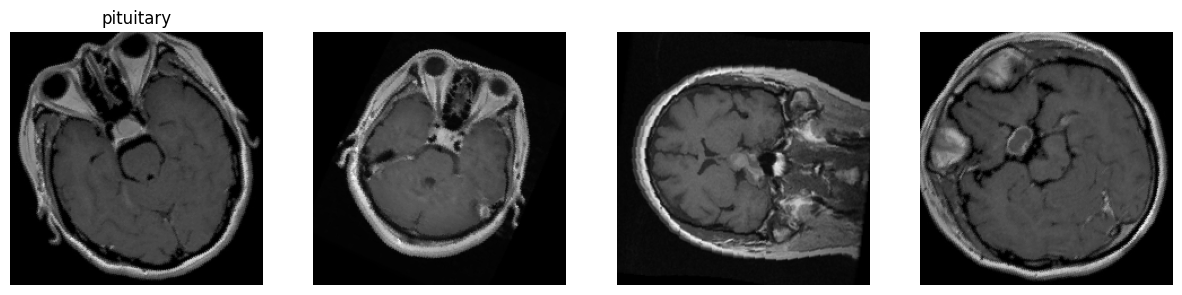

In [6]:
train_dataset = BrainTumorDataset(image_paths=train_image_paths, labels=train_labels, is_training=True)
test_dataset_full = BrainTumorDataset(image_paths=test_image_paths, labels=test_labels, is_training=False)

plot_sample_images(train_dataset)

## Create testing and validation datasets

### Split the testing data into testing and validation sets randomly

In [7]:
total_test_samples = len(test_dataset_full)
TEST_FRACTION = int(total_test_samples * 0.7)  # 70% for testing
VALIDATION_FRACTION = total_test_samples - TEST_FRACTION  # remaining for validation

test_dataset, validation_dataset = torch.utils.data.random_split(
    test_dataset_full,
    [TEST_FRACTION, VALIDATION_FRACTION]
)

In [8]:
print(f"Number of elements in training set: {len(train_dataset)}")
print(f"Number of elements in testing set: {len(test_dataset)}")
print(f"Number of elements in validation set: {len(validation_dataset)}")

Number of elements in training set: 12767
Number of elements in testing set: 1192
Number of elements in validation set: 512


In [9]:
print(f"Number of augmented elements in training set: {len(train_dataset) * 8}")
print(f"Number of augmented elements in testing set: {len(test_dataset) * 8}")
print(f"Number of augmented elements in validation set: {len(validation_dataset) * 8}")

Number of augmented elements in training set: 102136
Number of augmented elements in testing set: 9536
Number of augmented elements in validation set: 4096


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {device}')

Running on cpu


## Create data loaders for trainig, testing, and validation

In [11]:
train_gen = DataLoader(
    train_dataset, 
    batch_size=TRAIN_BATCHSIZE,
    pin_memory=True,
    shuffle=True
)

test_gen = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCHSIZE,
    pin_memory=True,
    shuffle=True
)

valid_gen = DataLoader(
    validation_dataset, 
    batch_size=EVAL_BATCHSIZE,
    pin_memory=True,
    shuffle=True
)

In [12]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [13]:
net = resnet50()

for param in net.parameters():
    param.requires_grad = True

n_inputs = net.fc.in_features

net.fc = nn.Sequential(nn.Linear(
    n_inputs, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 4),
)

# Change the first convolutional layer to accept a single channel
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

for name, child in net.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

net.to(device)

net

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), momentum=0.9, lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_final = deepcopy(net)

## Training loop

In [15]:
start_time = time.time()

best_prec1 = 2

b = None
train_b = None
test_b = None

for i in range(EPOCHS):
    trn_corr = 0
    tst_corr = 0
    
    e_start = time.time()
    
    for b, (X, y) in enumerate(train_gen):
        X, y = X.to(device), y.to(device)

        # forward pass image sample
        y_pred = net(X)
        
        # calculate loss
        loss = criterion(y_pred.float(), y.long())
        
        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        
        # if predicted label is correct as true label, calculate the sum for samples
        batch_corr = (predicted == y).sum()
        
        # increment train correct with correctly predicted labels per batch
        trn_corr += batch_corr
        
        # set optimizer gradients to zero
        optimizer.zero_grad()
        
        # back propagate with loss
        loss.backward()
        # perform optimizer step
        optimizer.step()
        
        scheduler.step()

    # set epoch's end time
    e_end = time.time()
    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)*TRAIN_BATCHSIZE}\nAccuracy: {trn_corr.item()*100/(TRAIN_BATCHSIZE*(b+1)):2.2f} %  Loss: {loss.item():2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes')

    # some metrics storage for visualization
    train_b = b
    train_losses.append(loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, (X, y) in enumerate(valid_gen):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)

            # forward pass image
            y_val = net(X)

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data

            # increment test correct with correctly predicted labels per batch
            tst_corr += (predicted == torch.argmax(y, dim=1)).sum()

    # get loss of validation set
    loss = criterion(y_val.float(), torch.argmax(y, dim=1).long())
    # print validation metrics
    print(f'Validation Accuracy {tst_corr.item()*100/(EVAL_BATCHSIZE*(b+1)):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # if current validation loss is less than previous iteration's validation loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)
    save_checkpoint({
            'epoch': i + 1,
            'state_dict': net.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time    

# print training summary
print(f"\nTraining Duration {end_time/60:.2f} minutes")
print(f"GPU memory used : {torch.cuda.memory_allocated()} kb")
print(f"GPU memory cached : {torch.cuda.memory_reserved()} kb") 


KeyboardInterrupt: 

## Testing loop

In [ ]:
net.eval()

total_test_examples = 0
num_correct_test = 0

with torch.no_grad():
    for batch_index, (inputs, targets) in enumerate(test_gen):
        inputs, targets = inputs.to(device), targets.to(device)
        
        predictions = net(inputs)
        _, predicted_class = predictions.max(1)
        
        total_test_examples += predicted_class.size(0)
        num_correct_test += predicted_class.eq(targets).sum().item()

test_acc = num_correct_test / total_test_examples
print(f"Test accuracy: {test_acc}")


## Plot results

In [ ]:
import matplotlib.pyplot as plt

epochs_list = list(range(EPOCHS))

plt.figure()
plt.plot(epochs_list, train_accs, 'b-', label='training set accuracy')
plt.plot(epochs_list, val_accs, 'r-', label='validation set accuracy')
plt.xlabel('epoch')
plt.ylabel('prediction accuracy')
plt.ylim(0.5, 1)
plt.title('Classifier training evolution:\nprediction accuracy over time')
plt.legend()
plt.show()